In [565]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Load the dataset
df = pd.read_csv('diabetes_prediction_dataset.csv')
df_encoded = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)
testDF = df_encoded.sample(frac=1).reset_index(drop=True)
x_unscaled = testDF.drop(['diabetes'], axis=1)
y = testDF['diabetes']

# Normalize the data
numerical_columns = x_unscaled.select_dtypes(include=np.number).columns
boolean_columns = x_unscaled.select_dtypes(include=bool).columns
scaler = StandardScaler()
temp = pd.DataFrame(scaler.fit_transform(x_unscaled[numerical_columns]), columns=numerical_columns)
x_scaled = pd.concat([temp, x_unscaled[boolean_columns]], axis=1)
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

Using device: cuda


In [566]:
X_train_tensor = torch.tensor(x_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
X_val_tensor = torch.tensor(x_val.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(x_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [567]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_size, encoding_dim, dropout):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [568]:
# Define input dimensions
input_dim = x_train.shape[1]
encoding_dim = 8

autoencoder_path = './models/autoencoder.pth'

# Initialize the model
autoencoder = Autoencoder(input_dim, 32, encoding_dim, 0.0).to(device)

# Load the model
autoencoder.load_state_dict(torch.load(autoencoder_path))
autoencoder.eval()

C:\Users\ROG\AppData\Local\Temp/ipykernel_23304/800231515.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(autoencoder_path))


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=32, out_features=13, bias=True)
  )
)

## Original MLP model

In [569]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_size, dropout):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Load the original MLP model
mlp_model_file = './models/mlp_model.pth'
input_dim = x_train.shape[1]
original_mlp = MLP(input_dim, 128, 0.3).to(device)
original_mlp.load_state_dict(torch.load(mlp_model_file))
original_mlp.eval()


test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize lists to store predictions and true labels
y_true_list = []
y_pred_list = []

# Evaluate the original MLP model
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = original_mlp(X_batch)  # Get predictions (probabilities from sigmoid)
        predictions = (outputs > 0.5).float()  # Convert probabilities to binary (0 or 1)

        y_true_list.extend(y_batch.cpu().numpy())  # Store true labels
        y_pred_list.extend(predictions.cpu().numpy())  # Store predictions

# Convert lists to NumPy arrays
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

# Calculate the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('TP:', conf_matrix[1, 1])
print('TN:', conf_matrix[0, 0])
print('FP:', conf_matrix[0, 1])
print('FN:', conf_matrix[1, 0])

# Calculate recall, precision, and F1 score
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
f1_score = 2 * (precision * recall) / (precision + recall)
print(f'Recall: {recall:.6f}')
print(f'Precision: {precision:.6f}')
print(f'F1 Score: {f1_score:.6f}')

C:\Users\ROG\AppData\Local\Temp/ipykernel_23304/2661790366.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_mlp.load_state_dict(torch.load(mlp_model_file))


Accuracy: 97.41%
TP: 848
TN: 13764
FP: 6
FN: 382
Recall: 0.689431
Precision: 0.992974
F1 Score: 0.813820


### TRYING OUT ERROR-CORRECTING MODEL

In [570]:
# Define the Bias Predictor Model
# class BiasPredictor(nn.Module):
#     def __init__(self, input_dim=1, hidden_size=128, dropout=0.2):
#         super(BiasPredictor, self).__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_size)
#         self.dropout1 = nn.Dropout(dropout)
        
#         self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
#         self.dropout2 = nn.Dropout(dropout)
        
#         self.fc3 = nn.Linear(hidden_size // 2, 1)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
        
#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)
        
#         return self.fc3(x)

class BiasPredictor(nn.Module):
    def __init__(self, input_dim=1, hidden_size=128, dropout=0.2):
        super(BiasPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout)
        
        self.fc3 = nn.Linear(hidden_size // 2, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.dropout1(x)
        
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = self.dropout2(x)
        
        return torch.tanh(self.fc3(x))



# Prepare the training data for the bias predictor
def prepare_bias_data(reconstruction_errors, x_test, original_probs, ground_truth):
    # Combine reconstruction errors with the existing normalized features
    features = np.hstack((reconstruction_errors.reshape(-1, 1), x_test.values))
    
    # Compute target biases
    target_bias = ground_truth - original_probs
    print("Minimum bias: ", np.min(target_bias))
    print("Maximum bias: ", np.max(target_bias))
    
    return torch.tensor(features, dtype=torch.float32), torch.tensor(target_bias, dtype=torch.float32)

def prepare_bias_data_scaled(reconstruction_errors, x_data, original_probs, ground_truth, reconstruction_scale):
    """
    Prepares data for the bias predictor by combining features and scaling reconstruction errors.
    """
    # Scale reconstruction errors
    scaled_reconstruction_errors = reconstruction_errors * reconstruction_scale
    
    # Combine scaled reconstruction errors with the existing features
    # features = np.hstack((scaled_reconstruction_errors.reshape(-1, 1), x_data.values))
    
    #######################################################################################################
    # use this for only reconstruction errors as the input feature
    
    features = scaled_reconstruction_errors.reshape(-1, 1)
    # print("Minimum scaled reconstruction error: ", np.min(scaled_reconstruction_errors))
    # print("Maximum scaled reconstruction error: ", np.max(scaled_reconstruction_errors))
    
    #######################################################################################################
    
    # Compute target biases
    target_bias = ground_truth - original_probs
    print("Minimum bias: ", np.min(target_bias))
    print("Maximum bias: ", np.max(target_bias))
    
    return torch.tensor(features, dtype=torch.float32), torch.tensor(target_bias, dtype=torch.float32)



def train_bias_predictor(features, target_bias, val_features, val_target_bias, epochs=1000, learning_rate=0.0001, patience=10, input_dim=1, hidden_size=128, dropout=0.2):
    model = BiasPredictor(input_dim = input_dim, hidden_size=hidden_size, dropout = dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')  # Initialize the best validation loss
    patience_counter = 0  # Counter for early stopping
    best_model_state = None

    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        predictions = model(features).squeeze()
        loss = criterion(predictions, target_bias)
        loss.backward()
        optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_predictions = model(val_features).squeeze()
            val_loss = criterion(val_predictions, val_target_bias)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()  # Save the best model state
        else:
            patience_counter += 1

        # Print progress
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

        # Stop training if patience is exceeded
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
            break

    # Load the best model state before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model


#####################################################################################################

# Train the Bias Predictor with Class Weights
# def train_bias_predictor_with_weights(features, target_bias, ground_truth, epochs=100, learning_rate=0.001):
# def train_bias_predictor_with_weights(features, target_bias, ground_truth, epochs=100, learning_rate=0.001, weight_positive_scale=1.0, weight_negative_scale=1.0):
#     model = BiasPredictor().to(device)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
#     # Define class weights
#     num_positive = np.sum(ground_truth == 1)
#     num_negative = np.sum(ground_truth == 0)
#     total = len(ground_truth)

#     weight_positive = (total / (2 * num_positive)) * weight_positive_scale
#     weight_negative = (total / (2 * num_negative)) * weight_negative_scale 

#     # Convert weights to tensors
#     class_weights = torch.tensor([weight_negative, weight_positive], dtype=torch.float32).to(device)
#     criterion = nn.MSELoss(reduction='none')  # Use 'none' to apply weights manually

#     for epoch in range(epochs):
#         model.train()
#         optimizer.zero_grad()
#         predictions = model(features).squeeze()
        
#         # Calculate weighted loss
#         loss = criterion(predictions, target_bias)
#         weights = torch.where(
#             target_bias > 0,  # Assign weights based on ground truth class
#             class_weights[1],  # Positive class weight
#             class_weights[0]   # Negative class weight
#         )
#         weighted_loss = torch.mean(loss * weights)
        
#         weighted_loss.backward()
#         optimizer.step()
#     return model

#####################################################################################################

def apply_bias_correction(bias_predictor, reconstruction_errors, x_test, original_probs):
    # Combine normalized reconstruction errors with other features
    # combined_features = np.hstack((reconstruction_errors.reshape(-1, 1), x_test.values))
    # features = torch.tensor(combined_features, dtype=torch.float32).to(next(bias_predictor.parameters()).device)
    
    #######################################################################################################
    # use this for only reconstruction errors as the input feature
    
    combined_features = reconstruction_errors.reshape(-1, 1)
    features = torch.tensor(combined_features, dtype=torch.float32).to(next(bias_predictor.parameters()).device)
    
    #######################################################################################################
    
    with torch.no_grad():
        bias_correction = bias_predictor(features).squeeze().cpu().numpy()
    
    print(np.min(bias_correction))
    print(np.max(bias_correction))
    
    # Multiply with a scaling factor
    bias_correction *= 1.2
    
    # Apply the correction and clip probabilities to [0, 1]
    corrected_probs = np.clip(original_probs + bias_correction, 0, 1)
    
    # Number of predictions that changed
    changed_predictions = np.sum((original_probs > 0.5).astype(int) != (corrected_probs > 0.5).astype(int))
    print(f"Number of changed predictions: {changed_predictions}")
    
    return corrected_probs

In [571]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F

with torch.no_grad():
    reconstructed_train = autoencoder(X_train_tensor).cpu().numpy()
reconstructed_errors_train = np.mean(np.square(x_train.values - reconstructed_train), axis=1)
mean_error_train = np.mean(reconstructed_errors_train)
std_error_train = np.std(reconstructed_errors_train)
reconstruction_errors_train_normalized = (reconstructed_errors_train - mean_error_train) / std_error_train
print("Max reconstruction error: ", np.max(reconstructed_errors_train))

with torch.no_grad():
    reconstructed_val = autoencoder(X_val_tensor).cpu().numpy()
reconstructed_errors_val = np.mean(np.square(x_val.values - reconstructed_val), axis=1)
mean_error_val = np.mean(reconstructed_errors_val)
std_error_val = np.std(reconstructed_errors_val)
reconstruction_errors_val_normalized = (reconstructed_errors_val - mean_error_val) / std_error_val

with torch.no_grad():
    y_pred_train = original_mlp(X_train_tensor).cpu().numpy().flatten()
    
with torch.no_grad():
    y_pred_val = original_mlp(X_val_tensor).cpu().numpy().flatten()
    
    
original_probs_train = y_pred_train
ground_truth_train = y_train.values

original_probs_val = y_pred_val
ground_truth_val = y_val.values


# Prepare the data for training
# features, target_bias = prepare_bias_data(reconstruction_errors_normalized, x_train, original_probs, ground_truth)

# if model does not exist
if not os.path.exists('./models/bias_predictor.pth'):
    features_train, target_bias_train = prepare_bias_data_scaled(reconstruction_errors_train_normalized, x_train, original_probs_train, ground_truth_train, reconstruction_scale=50)
    features_val, target_bias_val = prepare_bias_data_scaled(reconstruction_errors_val_normalized, x_val, original_probs_val, ground_truth_val, reconstruction_scale=50)

    # Move tensors to the same device as the model
    features_train, target_bias_train = features_train.to(device), target_bias_train.to(device)
    features_val, target_bias_val = features_val.to(device), target_bias_val.to(device)

    # Train the bias predictor
    bias_predictor = train_bias_predictor(features_train, target_bias_train, features_val, target_bias_val, epochs=5000, learning_rate=0.0001, patience=10)
                        
    # Apply bias correction during inference
    corrected_probs = apply_bias_correction(bias_predictor, reconstruction_errors_train_normalized, x_train, original_probs_train)

    # Convert probabilities to binary predictions
    corrected_predictions = (corrected_probs > 0.5).astype(int)
    # Calculate accuracy
    corrected_accuracy = accuracy_score(y_train, corrected_predictions)
    print(f"\nCorrected Accuracy: {corrected_accuracy * 100:.2f}%")

    # Calculate confusion matrix
    conf_matrix_corrected = confusion_matrix(y_train, corrected_predictions)

    tn, fp, fn, tp = conf_matrix_corrected.ravel()
    print("True Positives: ", tp)
    print("True Negatives: ", tn)
    print("False Positives: ", fp)
    print("False Negatives: ", fn)

    # Evaluate the original MLP model
    with torch.no_grad():
        x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
        y_pred_original = original_mlp(x_train_tensor).cpu().numpy().flatten()
        y_pred_original = (y_pred_original > 0.5).astype(int)  # Convert to binary

    original_accuracy = accuracy_score(y_train, y_pred_original)
    print(f"\nOriginal MLP Accuracy: {original_accuracy * 100:.2f}%")

    # Calculate confusion matrix
    conf_matrix_original = confusion_matrix(y_train, y_pred_original)

    original_tn, original_fp, original_fn, original_tp = conf_matrix_original.ravel()
    print("True Positives: ", original_tp)
    print("True Negatives: ", original_tn)
    print("False Positives: ", original_fp)
    print("False Negatives: ", original_fn)

else:
    # Load the trained bias predictor model
    bias_predictor = BiasPredictor().to(device)
    bias_predictor.load_state_dict(torch.load('./models/bias_predictor.pth'))

Max reconstruction error:  2.3131484528514887
Minimum bias:  -0.9999867677688599
Maximum bias:  0.9999999999856334
Minimum bias:  -0.7549043893814087
Maximum bias:  0.9999999989679031
Early stopping triggered at epoch 25. Best Val Loss: 0.0286
0.031692833
0.9871582
Number of changed predictions: 82

Corrected Accuracy: 97.08%
True Positives:  3972
True Negatives:  63981
False Positives:  93
False Negatives:  1954

Original MLP Accuracy: 97.08%
True Positives:  3934
True Negatives:  64025
False Positives:  49
False Negatives:  1992


In [572]:
with torch.no_grad():
    reconstructed_test = autoencoder(X_test_tensor).cpu().numpy()
reconstructed_errors_test = np.mean(np.square(x_test.values - reconstructed_test), axis=1)
mean_error_test = np.mean(reconstructed_errors_test)
std_error_test = np.std(reconstructed_errors_test)
reconstruction_errors_test_normalized = (reconstructed_errors_test - mean_error_test) / std_error_test

with torch.no_grad():
    x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32).to(device)
    y_pred_test = original_mlp(x_test_tensor).cpu().numpy().flatten()
    
original_probs_test = y_pred_test

original_accuracy_test = accuracy_score(y_test, (original_probs_test > 0.5).astype(int))


corrected_probs_test = apply_bias_correction(bias_predictor, reconstruction_errors_test_normalized, x_test, original_probs_test)

corrected_predictions_test = (corrected_probs_test > 0.5).astype(int)

corrected_accuracy_test = accuracy_score(y_test, corrected_predictions_test)
print(f"\nCorrected Accuracy on Test Set: {corrected_accuracy_test * 100:.2f}%")

conf_matrix_corrected_test = confusion_matrix(y_test, corrected_predictions_test)

tn, fp, fn, tp = conf_matrix_corrected_test.ravel()
print("True Positives: ", tp)
print("True Negatives: ", tn)
print("False Positives: ", fp)
print("False Negatives: ", fn)

print(f"\nOriginal Accuracy on Test Set: {original_accuracy_test * 100:.2f}%")

conf_matrix_original_test = confusion_matrix(y_test, (original_probs_test > 0.5).astype(int))

tn, fp, fn, tp = conf_matrix_original_test.ravel()
print("True Positives: ", tp)
print("True Negatives: ", tn)
print("False Positives: ", fp)
print("False Negatives: ", fn)

difference = corrected_accuracy_test - original_accuracy_test
difference_percent = difference/(1-original_accuracy_test)
print("Improvement: ", difference_percent*100)


0.03751152
0.9601753
Number of changed predictions: 13

Corrected Accuracy on Test Set: 97.42%
True Positives:  855
True Negatives:  13758
False Positives:  12
False Negatives:  375

Original Accuracy on Test Set: 97.41%
True Positives:  848
True Negatives:  13764
False Positives:  6
False Negatives:  382
Improvement:  0.2577319587628578


In [573]:
# if (corrected_accuracy_test > original_accuracy_test + 0.0010) and not os.path.exists('./models/bias_predictor.pth'):
#     # save the model
#     torch.save(bias_predictor.state_dict(), './models/bias_predictor.pth')
#     print("Model saved")
    
    


In [574]:
# # Identify the indices where the predictions changed
# changed_indices = np.where((original_probs_test > 0.5).astype(int) != corrected_predictions_test)[0]

# # Print the indices of the changed data points
# # print("Indices of changed data points:", changed_indices)

# print("Number of changed indices:", len(changed_indices))
# # Get the reconstruction error of the changed data points
# changed_reconstruction_errors = reconstruction_errors_test_normalized[changed_indices]

# # Define the ranges for the reconstruction errors
# ranges = [-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0, 20]

# # Count the number of changed indices within each range
# counts, bin_edges = np.histogram(changed_reconstruction_errors, bins=ranges)

# # Print the counts for each range
# for i in range(len(ranges) - 1):
#     print(f"Range {ranges[i]} to {ranges[i+1]}: {counts[i]}")

### Trying bias correction with individual reconstruction errors

In [575]:
def compute_feature_importance(model, X, y_true, metric=accuracy_score, n_repeats=5):
    model.eval()  # Ensure model is in evaluation mode
    X_base = X.clone()  # Keep a copy of the original data
    
    # Get baseline predictions and accuracy
    with torch.no_grad():
        y_pred_base = (model(X).detach().cpu().numpy().flatten() > 0.5).astype(int)
        baseline_score = metric(y_true.cpu().numpy().flatten(), y_pred_base)

    feature_importance = np.zeros(X.shape[1])  # Array to store importance for each feature

    for i in range(X.shape[1]):  # Loop through features
        scores = []
        for _ in range(n_repeats):  # Repeat for robustness
            X_permuted = X_base.clone()  # Clone original dataset
            permuted_feature = X_permuted[:, i].clone()  # Extract feature
            X_permuted[:, i] = permuted_feature[torch.randperm(X.shape[0])]  # Shuffle the feature

            # Get predictions with shuffled feature
            with torch.no_grad():
                y_pred_permuted = (model(X_permuted).detach().cpu().numpy().flatten() > 0.5).astype(int)
                score = metric(y_true.cpu().numpy().flatten(), y_pred_permuted)
            scores.append(score)

        feature_importance[i] = baseline_score - np.mean(scores)  # Drop in performance

    # Normalize so that importance values sum to 1
    feature_importance /= feature_importance.sum()

    return feature_importance


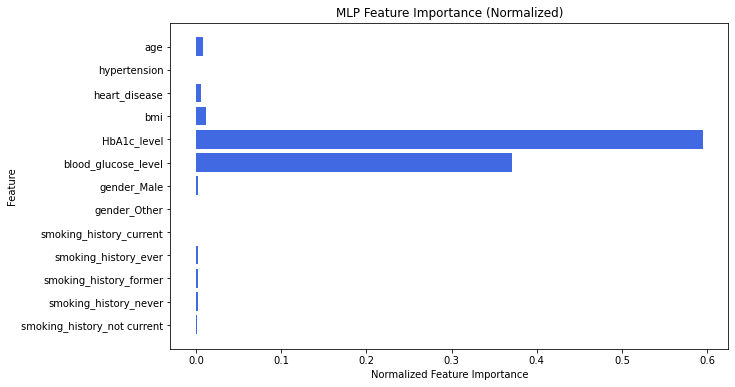

age: 0.0078
hypertension: -0.0006
heart_disease: 0.0058
bmi: 0.0116
HbA1c_level: 0.5952
blood_glucose_level: 0.3714
gender_Male: 0.0017
gender_Other: 0.0001
smoking_history_current: -0.0005
smoking_history_ever: 0.0023
smoking_history_former: 0.0021
smoking_history_never: 0.0023
smoking_history_not current: 0.0009


In [576]:

# Compute feature importance on validation data
feature_importance = compute_feature_importance(original_mlp, X_test_tensor, y_test_tensor)

# Get feature names if using pandas DataFrame
feature_names = x_test.columns.tolist()

# Plot normalized feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance, color="royalblue")
plt.xlabel("Normalized Feature Importance")
plt.ylabel("Feature")
plt.title("MLP Feature Importance (Normalized)")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {feature_importance[i]:.4f}")


In [577]:
# Get reconstruction error by column

with torch.no_grad():
    reconstructed_train = autoencoder(X_train_tensor).cpu().numpy()
    reconstructed_val = autoencoder(X_val_tensor).cpu().numpy()
    reconstructed_test = autoencoder(X_test_tensor).cpu().numpy()
    
    
reconstructed_errors_train = np.abs((x_train.values - reconstructed_train) / (x_train.values+1e-8)) * 100
reconstructed_errors_val = np.abs((x_val.values - reconstructed_val) / (x_val.values+1e-8)) * 100
reconstructed_errors_test = np.abs((x_test.values - reconstructed_test) / (x_test.values+1e-8)) * 100

# Normalize based on column
# x_scaler = StandardScaler()
# x_scaler = RobustScaler()
x_scaler = MinMaxScaler()

reconstructed_train_normalized = x_scaler.fit_transform(reconstructed_errors_train)
reconstructed_val_normalized = x_scaler.transform(reconstructed_errors_val)
reconstructed_test_normalized = x_scaler.transform(reconstructed_errors_test)

# only keep the 4th and 5th columns of the normalized reconstruction errors
reconstructed_train_normalized = reconstructed_train_normalized[:, 4:6]
reconstructed_val_normalized = reconstructed_val_normalized[:, 4:6]
reconstructed_test_normalized = reconstructed_test_normalized[:, 4:6]


In [578]:
# Get MLP prediction
with torch.no_grad():
    y_pred_train = original_mlp(X_train_tensor).cpu().numpy().flatten()
    y_pred_val = original_mlp(X_val_tensor).cpu().numpy().flatten()
    y_pred_test = original_mlp(X_test_tensor).cpu().numpy().flatten()
    
ground_truth_train = y_train.values
ground_truth_val = y_val.values
ground_truth_test = y_test.values

bias_train = ground_truth_train - y_pred_train
bias_val = ground_truth_val - y_pred_val
bias_test = ground_truth_test - y_pred_test

# y_scaler = StandardScaler()
# y_scaler = RobustScaler()
y_scaler = MinMaxScaler()

bias_train_normalized = y_scaler.fit_transform(bias_train.reshape(-1, 1)).flatten()
bias_val_normalized = y_scaler.transform(bias_val.reshape(-1, 1)).flatten()
bias_test_normalized = y_scaler.transform(bias_test.reshape(-1, 1)).flatten()

In [579]:
# def train_bias_predictor(features, target_bias, val_features, val_target_bias, 
#                          epochs=1000, learning_rate=0.0001, patience=10, 
#                          input_dim=2, hidden_size=128, dropout=0.2, batch_size=32):

#     model = BiasPredictor(input_dim=input_dim, hidden_size=hidden_size, dropout=dropout).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     criterion = nn.MSELoss()

#     best_val_loss = float('inf')
#     patience_counter = 0
#     best_model_state = None

#     # Reshape target_bias to (batch_size, 1)
#     target_bias = target_bias.view(-1, 1)
#     val_target_bias = val_target_bias.view(-1, 1)

#     # Create DataLoaders
#     train_dataset = TensorDataset(features, target_bias)
#     val_dataset = TensorDataset(val_features, val_target_bias)

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#     for epoch in range(epochs):
#         model.train()
#         total_train_loss = 0.0

#         # Training loop
#         for batch_features, batch_targets in train_loader:
#             batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)

#             optimizer.zero_grad()
#             predictions = model(batch_features).squeeze()
#             loss = criterion(predictions, batch_targets)
#             loss.backward()
#             optimizer.step()
            
#             total_train_loss += loss.item()

#         # Validation loop
#         model.eval()
#         total_val_loss = 0.0
#         with torch.no_grad():
#             for val_batch_features, val_batch_targets in val_loader:
#                 val_batch_features, val_batch_targets = val_batch_features.to(device), val_batch_targets.to(device)

#                 val_predictions = model(val_batch_features).squeeze()
#                 val_loss = criterion(val_predictions, val_batch_targets)
                
#                 total_val_loss += val_loss.item()

#         avg_train_loss = total_train_loss / len(train_loader)
#         avg_val_loss = total_val_loss / len(val_loader)

#         # Early stopping check
#         if avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss
#             patience_counter = 0
#             best_model_state = model.state_dict()  # Save best model
#         else:
#             patience_counter += 1

#         # Print progress
#         print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

#         if patience_counter >= patience:
#             print(f"Early stopping triggered at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
#             break

#     # Load best model before returning
#     if best_model_state is not None:
#         model.load_state_dict(best_model_state)

#     return model

class WeightedMSELoss(nn.Module):
    def __init__(self, scale_factor=2.0):
        super(WeightedMSELoss, self).__init__()
        self.scale_factor = scale_factor

    def forward(self, predictions, targets):
        weights = 1 + self.scale_factor * torch.abs(targets)  # Higher weight for large biases
        return torch.mean(weights * (predictions - targets) ** 2)




def train_bias_predictor(features, target_bias, val_features, val_target_bias, 
                         epochs=1000, learning_rate=0.0001, patience=10, 
                         input_dim=2, hidden_size=128, dropout=0.2, batch_size=32, scale_factor=1.25):

    model = BiasPredictor(input_dim=input_dim, hidden_size=hidden_size, dropout=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # criterion = nn.MSELoss()
    criterion = WeightedMSELoss(scale_factor=scale_factor)

    # Reshape target_bias to (batch_size, 1)
    target_bias = target_bias.view(-1, 1)
    val_target_bias = val_target_bias.view(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(features, target_bias)
    val_dataset = TensorDataset(val_features, val_target_bias)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0

        # Training loop
        for batch_features, batch_targets in train_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)

            optimizer.zero_grad()
            predictions = model(batch_features)  # Ensure output shape is (batch_size, 1)
            loss = criterion(predictions, batch_targets.view(-1, 1))  # Match shapes
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()

        # Validation loop
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for val_batch_features, val_batch_targets in val_loader:
                val_batch_features, val_batch_targets = val_batch_features.to(device), val_batch_targets.to(device)

                val_predictions = model(val_batch_features)  # Ensure correct shape
                val_loss = criterion(val_predictions, val_batch_targets.view(-1, 1))  # Match shapes
                
                total_val_loss += val_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()  # Save best model
        else:
            patience_counter += 1

        # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
            break

    # Load best model before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model


In [580]:
reconstructed_train_tensor = torch.tensor(reconstructed_train_normalized, dtype=torch.float32).to(device)
bias_train_tensor = torch.tensor(bias_train_normalized, dtype=torch.float32).to(device)
bias_train_tensor = bias_train_tensor.view(-1,1)

reconstructed_val_tensor = torch.tensor(reconstructed_val_normalized, dtype=torch.float32).to(device)
bias_val_tensor = torch.tensor(bias_val_normalized, dtype=torch.float32).to(device)
bias_val_tensor = bias_val_tensor.view(-1,1)

# model = train_bias_predictor(
#     reconstructed_train_tensor, bias_train_tensor, 
#     reconstructed_val_tensor, bias_val_tensor,
#     epochs=1000, learning_rate=0.0005, patience=10, 
#     input_dim=2, hidden_size=64, dropout=0.2, batch_size=32
# )


In [581]:
# model.eval()

# # try on test set
# reconstructed_test_tensor = torch.tensor(reconstructed_test_normalized, dtype=torch.float32).to(device)

# with torch.no_grad():
#     bias_test_pred = model(reconstructed_test_tensor).cpu().numpy().flatten()


In [582]:
# bias_test_pred_unscaled = y_scaler.inverse_transform(bias_test_pred.reshape(-1, 1)).flatten()

# bias_test_pred_unscaled_scaled = bias_test_pred_unscaled
# # bias_test_pred_unscaled_scaled = np.clip(bias_test_pred_unscaled_scaled, -0.5, 0.5)
# corrected_probs_test = y_pred_test + bias_test_pred_unscaled_scaled

In [583]:
# # convert corrected prob test to binary
# corrected_predictions_test = (corrected_probs_test > 0.5).astype(int)

# # Calculate accuracy
# corrected_accuracy_test = accuracy_score(ground_truth_test, corrected_predictions_test)
# print(f"Corrected Accuracy on Test Set: {corrected_accuracy_test * 100:.2f}%")

# original_accuracy_test = accuracy_score(ground_truth_test, (y_pred_test > 0.5).astype(int))
# print(f"Original Accuracy on Test Set: {original_accuracy_test * 100:.2f}%")

In [584]:
# conf_matrix_original_test = confusion_matrix(y_test, (original_probs_test > 0.5).astype(int))

# tn, fp, fn, tp = conf_matrix_original_test.ravel()
# recall_original = tp / (tp + fn)
# precision_original = tp / (tp + fp)
# f1_score_original = 2 * (precision_original * recall_original) / (precision_original + recall_original)
# print("Original:")
# print("True Positives: ", tp)
# print("True Negatives: ", tn)
# print("False Positives: ", fp)
# print("False Negatives: ", fn)
# print("Recall: ", recall_original)
# print("Precision: ", precision_original)
# print("F1 Score: ", f1_score_original)


# conf_matrix_corrected_test = confusion_matrix(y_test, corrected_predictions_test)

# tn, fp, fn, tp = conf_matrix_corrected_test.ravel()
# recall_corrected = tp / (tp + fn)
# precision_corrected = tp / (tp + fp)
# f1_score_corrected = 2 * (precision_corrected * recall_corrected) / (precision_corrected + recall_corrected)
# print("\n\nCorrected:")
# print("True Positives: ", tp)
# print("True Negatives: ", tn)
# print("False Positives: ", fp)
# print("False Negatives: ", fn)
# print("Recall: ", recall_corrected)
# print("Precision: ", precision_corrected)
# print("F1 Score: ", f1_score_corrected)

### Trying bias correction with combined reconstruction errors (percentage)

In [585]:
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [586]:
X_train_tensor = torch.tensor(x_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
X_val_tensor = torch.tensor(x_val.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(x_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [587]:
with torch.no_grad():
    reconstructed_train = autoencoder(X_train_tensor).cpu().numpy()
    reconstructed_val = autoencoder(X_val_tensor).cpu().numpy()
    reconstructed_test = autoencoder(X_test_tensor).cpu().numpy()
    
temp_train = np.abs((x_train.values - reconstructed_train) / (x_train.values+1e-8)) * 100
temp_val = np.abs((x_val.values - reconstructed_val) / (x_val.values+1e-8)) * 100
temp_test = np.abs((x_test.values - reconstructed_test) / (x_test.values+1e-8)) * 100


# get mean per for each row of temp
reconstruction_percent_train = np.mean(temp_train, axis=1)
reconstruction_percent_val = np.mean(temp_val, axis=1)
reconstruction_percent_test = np.mean(temp_test, axis=1)


In [588]:
x_scaler = StandardScaler()
# x_scaler = RobustScaler()
# x_scaler = MinMaxScaler()

reconstruction_percent_train_normalized = x_scaler.fit_transform(reconstruction_percent_train.reshape(-1, 1)).flatten()
reconstruction_percent_val_normalized = x_scaler.transform(reconstruction_percent_val.reshape(-1, 1)).flatten()
reconstruction_percent_test_normalized = x_scaler.transform(reconstruction_percent_test.reshape(-1, 1)).flatten()

In [589]:
# Get MLP prediction
with torch.no_grad():
    y_pred_train = original_mlp(X_train_tensor).cpu().numpy().flatten()
    y_pred_val = original_mlp(X_val_tensor).cpu().numpy().flatten()
    y_pred_test = original_mlp(X_test_tensor).cpu().numpy().flatten()
    
ground_truth_train = y_train.values
ground_truth_val = y_val.values
ground_truth_test = y_test.values

bias_train = ground_truth_train - y_pred_train
bias_val = ground_truth_val - y_pred_val
bias_test = ground_truth_test - y_pred_test

# y_scaler = StandardScaler()
# y_scaler = RobustScaler()
y_scaler = StandardScaler()

bias_train_normalized = y_scaler.fit_transform(bias_train.reshape(-1, 1)).flatten()
bias_val_normalized = y_scaler.transform(bias_val.reshape(-1, 1)).flatten()
bias_test_normalized = y_scaler.transform(bias_test.reshape(-1, 1)).flatten()

In [593]:
reconstructed_train_tensor = torch.tensor(reconstruction_percent_train_normalized, dtype=torch.float32).view(-1,1).to(device)
bias_train_tensor = torch.tensor(bias_train_normalized, dtype=torch.float32).to(device)
bias_train_tensor = bias_train_tensor.view(-1,1)

reconstructed_val_tensor = torch.tensor(reconstruction_percent_val_normalized, dtype=torch.float32).view(-1,1).to(device)
bias_val_tensor = torch.tensor(bias_val_normalized, dtype=torch.float32).to(device)
bias_val_tensor = bias_val_tensor.view(-1,1)


In [594]:

# model = train_bias_predictor(
#     reconstructed_train_tensor, bias_train_tensor, 
#     reconstructed_val_tensor, bias_val_tensor,
#     epochs=1000, learning_rate=0.01, patience=10, 
#     input_dim=1, hidden_size=64, dropout=0.1, batch_size=128, scale_factor=1.25
# )


In [ ]:
# model.eval()

# # try on test set
reconstructed_test_tensor = torch.tensor(reconstruction_percent_test_normalized, dtype=torch.float32).view(-1,1).to(device)

# with torch.no_grad():
#     bias_test_pred = model(reconstructed_test_tensor).cpu().numpy().flatten()

In [596]:
# bias_test_pred_unscaled = y_scaler.inverse_transform(bias_test_pred.reshape(-1, 1)).flatten()

# corrected_probs_test = y_pred_test + bias_test_pred_unscaled

In [597]:
# # convert corrected prob test to binary
# corrected_predictions_test = (corrected_probs_test > 0.5).astype(int)

# # Calculate accuracy
# corrected_accuracy_test = accuracy_score(ground_truth_test, corrected_predictions_test)
# print(f"Corrected Accuracy on Test Set: {corrected_accuracy_test * 100:.2f}%")

# original_accuracy_test = accuracy_score(ground_truth_test, (y_pred_test > 0.5).astype(int))
# print(f"Original Accuracy on Test Set: {original_accuracy_test * 100:.2f}%")

In [598]:
# conf_matrix_original_test = confusion_matrix(y_test, (original_probs_test > 0.5).astype(int))

# tn, fp, fn, tp = conf_matrix_original_test.ravel()
# recall_original = tp / (tp + fn)
# precision_original = tp / (tp + fp)
# f1_score_original = 2 * (precision_original * recall_original) / (precision_original + recall_original)
# print("Original:")
# print("True Positives: ", tp)
# print("True Negatives: ", tn)
# print("False Positives: ", fp)
# print("False Negatives: ", fn)
# print("Recall: ", recall_original)
# print("Precision: ", precision_original)
# print("F1 Score: ", f1_score_original)


# conf_matrix_corrected_test = confusion_matrix(y_test, corrected_predictions_test)

# tn, fp, fn, tp = conf_matrix_corrected_test.ravel()
# recall_corrected = tp / (tp + fn)
# precision_corrected = tp / (tp + fp)
# f1_score_corrected = 2 * (precision_corrected * recall_corrected) / (precision_corrected + recall_corrected)
# print("\n\nCorrected:")
# print("True Positives: ", tp)
# print("True Negatives: ", tn)
# print("False Positives: ", fp)
# print("False Negatives: ", fn)
# print("Recall: ", recall_corrected)
# print("Precision: ", precision_corrected)
# print("F1 Score: ", f1_score_corrected)

In [599]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))

# # Histogram
# plt.subplot(1, 2, 1)
# plt.hist(y_pred_train, bins=50, edgecolor='black', alpha=0.7)
# plt.xlabel("Bias Values")
# plt.ylabel("Frequency")
# plt.title("Histogram of bias_train")

# # Box Plot
# plt.subplot(1, 2, 2)
# plt.boxplot(y_pred_train, vert=False)
# plt.xlabel("Bias Values")
# plt.title("Box Plot of bias_train")

# plt.tight_layout()
# plt.show()


In [600]:
def evaluate_model(model, reconstructed_test_tensor, y_pred_test, ground_truth_test):
    """Runs evaluation on the test set and returns accuracy, recall, precision, F1 score"""
    with torch.no_grad():
        bias_test_pred = model(reconstructed_test_tensor).cpu().numpy().flatten()
    
    bias_test_pred_unscaled = y_scaler.inverse_transform(bias_test_pred.reshape(-1, 1)).flatten()
    corrected_probs_test = y_pred_test + bias_test_pred_unscaled
    corrected_predictions_test = (corrected_probs_test > 0.5).astype(int)
    
    # Compute metrics
    original_accuracy = accuracy_score(ground_truth_test, (y_pred_test > 0.5).astype(int))
    corrected_accuracy = accuracy_score(ground_truth_test, corrected_predictions_test)
    
    conf_matrix_original = confusion_matrix(ground_truth_test, (y_pred_test > 0.5).astype(int))
    tn, fp, fn, tp = conf_matrix_original.ravel()
    recall_original = tp / (tp + fn)
    precision_original = tp / (tp + fp)
    f1_score_original = 2 * (precision_original * recall_original) / (precision_original + recall_original)
    
    conf_matrix_corrected = confusion_matrix(ground_truth_test, corrected_predictions_test)
    tn, fp, fn, tp = conf_matrix_corrected.ravel()
    recall_corrected = tp / (tp + fn)
    precision_corrected = tp / (tp + fp)
    f1_score_corrected = 2 * (precision_corrected * recall_corrected) / (precision_corrected + recall_corrected)
    
    return (original_accuracy, corrected_accuracy, recall_original, precision_original, f1_score_original,
            recall_corrected, precision_corrected, f1_score_corrected)

In [ ]:
import itertools
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, confusion_matrix

# Define hyperparameter grid
learning_rates = [0.001, 0.005, 0.01]
hidden_sizes = [16, 32, 64]
dropouts = [0.0,0.1, 0.2]
scale_factors = [1.0, 1.25, 1.5]

# Number of runs per configuration
num_runs = 5

# Store results
results = []

total_combinations = len(learning_rates) * len(hidden_sizes) * len(dropouts) * len(scale_factors)
count = 0
# Iterate over hyperparameter combinations
for lr, hidden_size, dropout, scale_factor in itertools.product(learning_rates, hidden_sizes, dropouts, scale_factors):
    print(f"Training with LR={lr}, Hidden={hidden_size}, Dropout={dropout}, Scale Factor={scale_factor}")
    print(f"Combination {count+1}/{total_combinations}")
    count += 1
    
    # Store results for multiple runs
    run_results = []
    for _ in range(num_runs):
        model = train_bias_predictor(
            reconstructed_train_tensor, bias_train_tensor, 
            reconstructed_val_tensor, bias_val_tensor,
            epochs=1000, learning_rate=lr, patience=10, 
            input_dim=1, hidden_size=hidden_size, dropout=dropout, scale_factor=scale_factor
        )
        model.eval()
        run_results.append(evaluate_model(model, reconstructed_test_tensor, y_pred_test, ground_truth_test))
    
    # Compute averages across runs
    avg_results = [sum(x) / num_runs for x in zip(*run_results)]
    
    # Store in results list
    results.append([lr, hidden_size, dropout, scale_factor] + avg_results)

# Convert to DataFrame
columns = ["Learning Rate", "Hidden Size", "Dropout", "Scale Factor",
           "Original Accuracy", "Corrected Accuracy", 
           "Original Recall", "Original Precision", "Original F1 Score",
           "Corrected Recall", "Corrected Precision", "Corrected F1 Score"]
df_results = pd.DataFrame(results, columns=columns)

# Save to CSV
df_results.to_csv("hyperparameter_tuning_results.csv", index=False)
print("Hyperparameter tuning complete. Results saved to hyperparameter_tuning_results.csv")

In [ ]:
# sort by corrected F1 score
df_results = df_results.sort_values(by='Corrected F1 Score', ascending=False)
df_results.head(10)